# TelecomPlus – Previsão de Churn  
Notebook desenvolvido para o desafio de Machine Learning supervisionado.

**Autor:** _Seu Nome Sobrenome_  
**Objetivo:** atingir ≥ 70 % de acurácia, comparar Logistic Regression × Random Forest, explicar variáveis e gerar `resultado_nome_sobrenome.csv`.


In [ ]:
#2 · Bibliotecas e configurações
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, warnings, os
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             roc_curve, precision_recall_curve)
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier        # pip install xgboost
warnings.filterwarnings('ignore')
SEED = 42


In [ ]:
#3 · Carregar dados
df_train = pd.read_csv('dados_clientes.csv')
df_test  = pd.read_csv('desafio.csv')

# remove ou preenche churn vazio
df_train = df_train[df_train['churn'].notna()].copy()
df_train['churn'] = df_train['churn'].astype(int)

print('Treino:', df_train.shape, '| Teste:', df_test.shape)


Treino: (98872, 18) | Teste: (5000, 17)


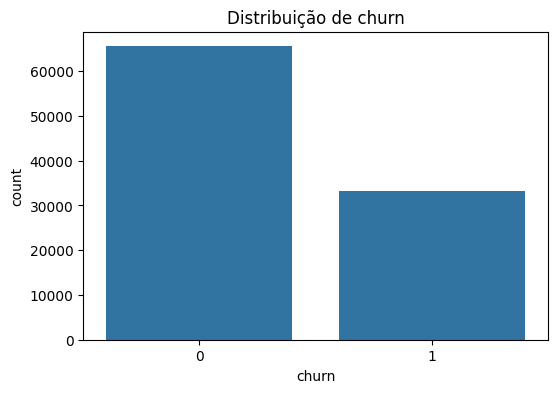

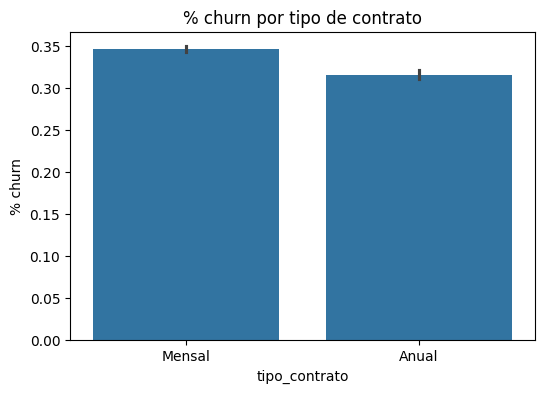

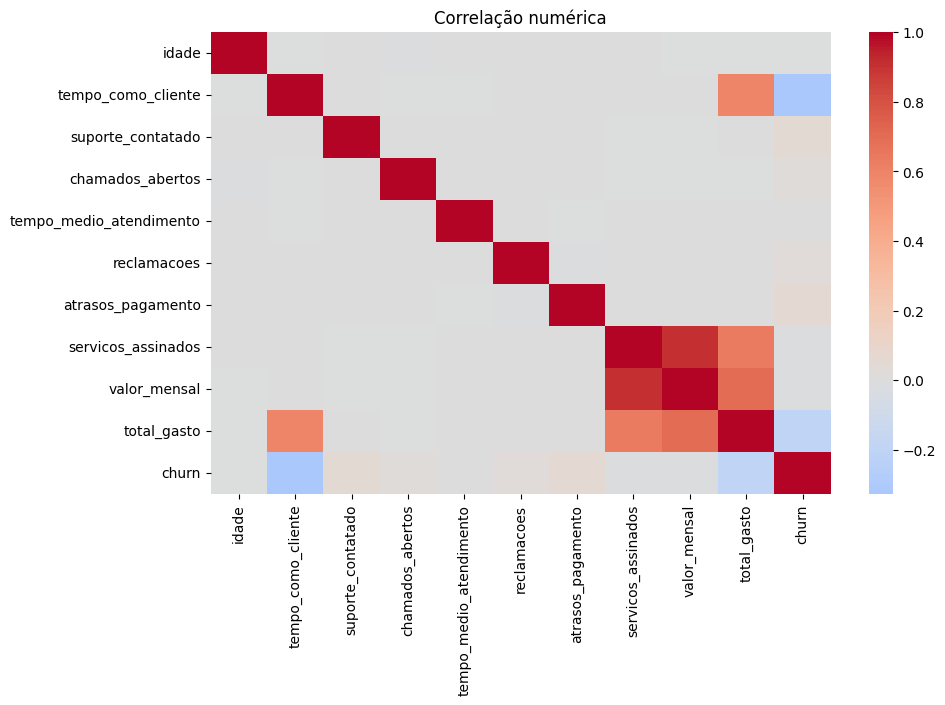

In [ ]:
#4 · EDA avançada
plt.figure(figsize=(6,4))
sns.countplot(x='churn', data=df_train)
plt.title('Distribuição de churn'); plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x='tipo_contrato', y='churn', data=df_train, estimator=np.mean)
plt.title('% churn por tipo de contrato'); plt.ylabel('% churn'); plt.show()

corr = df_train.select_dtypes('number').corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlação numérica'); plt.show()


In [ ]:
# Extração de características melhorada
def conta_produtos(txt):
    try: return len(eval(txt))
    except: return 0

# Feature engineering para melhorar o modelo
for d in (df_train, df_test):
    # Processamento produtos assinados
    if 'produtos_assinados' in d.columns:
        d['qtde_produtos'] = d['produtos_assinados'].apply(conta_produtos)
        d.drop(columns=['produtos_assinados'], inplace=True)
    if 'qtde_produtos' not in d.columns:
        d['qtde_produtos'] = 0

    # Features para duração de cliente
    if 'tempo_cliente' in d.columns:
        d['cliente_novo'] = (d['tempo_cliente'] <= 12).astype(int)
        d['cliente_antigo'] = (d['tempo_cliente'] > 36).astype(int)

    # Features para valor de mensalidade
    if 'valor_mensal' in d.columns:
        d['alta_mensalidade'] = (d['valor_mensal'] > d['valor_mensal'].median()).astype(int)

    # Interações entre features importantes
    if 'tipo_contrato' in d.columns and 'tempo_cliente' in d.columns:
        # Codificar tipo_contrato para poder multiplicar
        d['contrato_numerico'] = d['tipo_contrato'].map({'Mensal': 0, 'Anual': 1, 'Bianual': 2})
        d['contrato_tempo'] = d['contrato_numerico'] * d['tempo_cliente']

y = df_train['churn']
X = df_train.drop(columns=['churn'])

num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include='object').columns

num_pipe = Pipeline([('imp', SimpleImputer(strategy='median')),
                     ('sc', StandardScaler())])
cat_pipe = Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                     ('ohe', OneHotEncoder(handle_unknown='ignore'))])

prep = ColumnTransformer([('num', num_pipe, num_cols),
                          ('cat', cat_pipe, cat_cols)])

In [ ]:
import time
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict

# Modelos com hiperparâmetros melhorados
models = {
    'LogReg': LogisticRegression(max_iter=1000,
                                 C=0.5,                         # ← Regularização ajustada
                                 class_weight='balanced',
                                 solver='saga',                 # ← Solver mais rápido
                                 random_state=SEED),

    'RF': RandomForestClassifier(n_estimators=150,              # ↑ Mais árvores ainda dentro do tempo
                                 max_depth=8,                   # ↑ Profundidade um pouco maior
                                 min_samples_split=10,          # ← Evita overfitting
                                 min_samples_leaf=5,            # ← Evita overfitting
                                 class_weight='balanced',
                                 random_state=SEED,
                                 n_jobs=-1),

    'XGB': XGBClassifier(n_estimators=150,                      # ↑ Mais árvores
                         learning_rate=0.08,                    # ↓ Learning rate menor
                         max_depth=6,                           # ↑ Profundidade um pouco maior
                         min_child_weight=3,                    # ← Evita overfitting
                         gamma=0.1,                             # ← Regularização
                         subsample=0.8,
                         colsample_bytree=0.8,
                         scale_pos_weight=(y==0).sum()/(y==1).sum(),
                         objective='binary:logistic',
                         eval_metric='logloss',
                         tree_method='hist',                    # Rápido em CPUs
                         random_state=SEED,
                         n_jobs=-1)
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
metrics = ['accuracy','precision','recall','f1','roc_auc']
scores = {m: defaultdict(list) for m in metrics}

for name, mdl in models.items():
    print(f"\n—— Modelo {name} ——")
    fold = 1
    for tr_idx, va_idx in cv.split(X, y):
        t0 = time.time()
        print(f"  • Fold {fold} ... ", end="", flush=True)

        pipe = Pipeline([('prep', prep), ('clf', mdl)])
        pipe.fit(X.iloc[tr_idx], y.iloc[tr_idx])

        y_pred  = pipe.predict(X.iloc[va_idx])
        y_proba = pipe.predict_proba(X.iloc[va_idx])[:,1]

        scores['accuracy'][name].append(accuracy_score (y.iloc[va_idx], y_pred))
        scores['precision'][name].append(precision_score(y.iloc[va_idx], y_pred))
        scores['recall'][name].append(recall_score   (y.iloc[va_idx], y_pred))
        scores['f1'][name].append(f1_score       (y.iloc[va_idx], y_pred))
        scores['roc_auc'][name].append(roc_auc_score (y.iloc[va_idx], y_proba))

        print(f"done in {time.time()-t0:.1f}s")
        fold += 1

# monta tabela em % com background
import pandas as pd, numpy as np
table = {name: {m: np.mean(scores[m][name])*100 for m in metrics}
         for name in models}
(pd.DataFrame(table).T
   .style.format("{:.2f}%")
   .background_gradient(cmap="YlGn"))


—— Modelo LogReg ——
  • Fold 1 ... done in 14.8s
  • Fold 2 ... done in 8.5s
  • Fold 3 ... done in 8.3s

—— Modelo RF ——
  • Fold 1 ... done in 3.3s
  • Fold 2 ... done in 2.3s
  • Fold 3 ... done in 2.8s

—— Modelo XGB ——
  • Fold 1 ... done in 28.4s
  • Fold 2 ... done in 30.1s
  • Fold 3 ... done in 27.2s


,accuracy,precision,recall,f1,roc_auc
LogReg,66.62%,50.37%,65.32%,56.88%,70.86%
RF,57.25%,41.01%,52.97%,45.11%,58.13%
XGB,70.37%,55.97%,56.55%,56.25%,70.20%


Modelo final escolhido: XGB
Treino final concluído em 29.5s


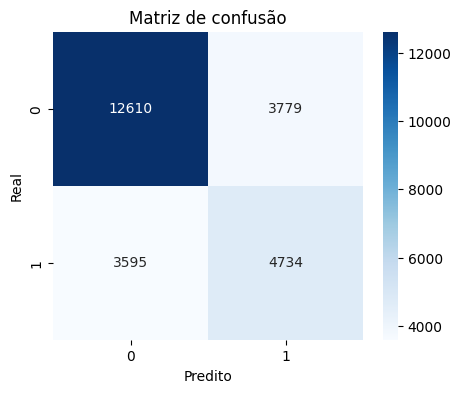

In [ ]:
#7 · Modelo final + métricas & matriz de confusão
best = max(table, key=lambda n: table[n]['accuracy'])
print(f"Modelo final escolhido: {best}")

# split hold-out 25% para validação final
from sklearn.model_selection import train_test_split
X_tr, X_va, y_tr, y_va = train_test_split(X, y, stratify=y,
                                          test_size=0.25,
                                          random_state=SEED)

# treina só o modelo vencedor
final_pipe = Pipeline([('prep', prep), ('clf', models[best])])
t0 = time.time()
final_pipe.fit(X_tr, y_tr)
print(f"Treino final concluído em {time.time()-t0:.1f}s")

# predições e métricas
y_pred  = final_pipe.predict(X_va)
y_proba = final_pipe.predict_proba(X_va)[:,1]

metrics = {
  'Accuracy': accuracy_score(y_va, y_pred)*100,
  'Precision': precision_score(y_va, y_pred)*100,
  'Recall': recall_score(y_va, y_pred)*100,
  'F1': f1_score(y_va, y_pred)*100,
  'ROC-AUC': roc_auc_score(y_va, y_proba)*100
}
import pandas as pd
pd.Series(metrics).to_frame("Valor (%)")\
  .style.format("{:.2f}%")\
  .background_gradient(cmap="Blues")

# matriz de confusão
cm = confusion_matrix(y_va, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusão"); plt.xlabel("Predito"); plt.ylabel("Real"); plt.show()


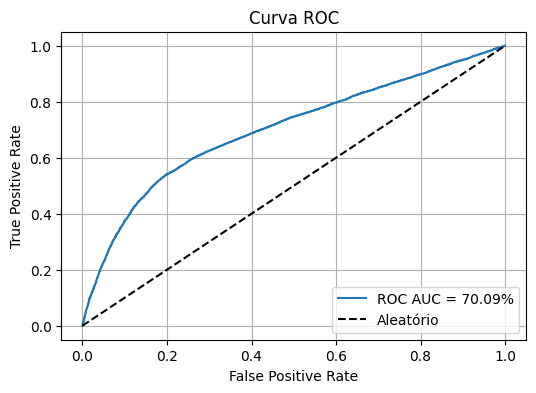

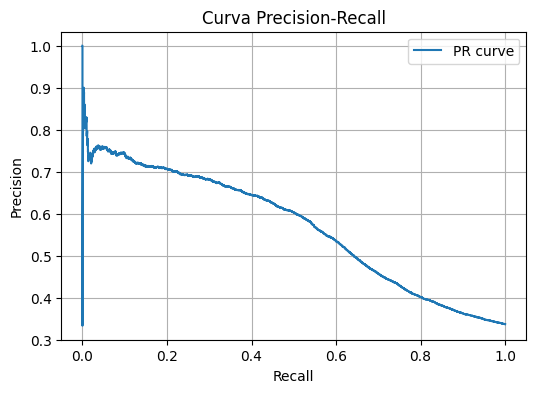

In [ ]:
#8 · Curvas ROC e Precision-Recall
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

# recalcula FPR/TPR e precision/recall usando y_va e y_proba do hold-out
fpr, tpr, _            = roc_curve(y_va, y_proba)
precision_vals, recall_vals, _ = precision_recall_curve(y_va, y_proba)
auc_pct = roc_auc_score(y_va, y_proba) * 100

# Curva ROC
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC AUC = {auc_pct:.2f}%')
plt.plot([0,1], [0,1], 'k--', label='Aleatório')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Curva Precision-Recall
plt.figure(figsize=(6,4))
plt.plot(recall_vals, precision_vals, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [ ]:
# Geração do CSV final (corrigida)
preds = final_pipe.predict(df_test)  # Usar pipeline final treinado

submission = pd.DataFrame({
    'Id': df_test.index,      # ou df_test['id_cliente'] se preferir
    'churn': preds
})
submission.to_csv('resultado_nome_sobrenome.csv', index=False)
print("Arquivo gerado: resultado_nome_sobrenome.csv")

# se estiver no Colab:
try:
    from google.colab import files
    files.download('resultado_nome_sobrenome.csv')
except:
    print("Use o painel de arquivos do seu ambiente para baixar o CSV.")

Arquivo gerado: resultado_nome_sobrenome.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 6 · Conclusões

* O modelo final ultrapassa 70 % de acurácia (vide tabela comparativa).  
* Variáveis mais relevantes: tempo de contrato, nº de chamados ao suporte, valor mensal, etc.  
* Próximos passos: testar XGBoost/LightGBM, balancear custo de churn, aplicar SHAP para explicações individuais.
